# Сборка датасета. Анализ данных

# <a id="0">Содержание</a>

- <a href="#1">Открытие данных и их описание</a>
- <a href="#2">Сборка датасета. Анализ данных</a>  
    - <a href="#21">Агрегация по пользователям</a>
    - <a href="#22">Обработка категориальных и временных признаков</a>
    - <a href="#23">Поиск и обработка аномалий в данных</a>
    - <a href="#24">Добавление новых признаков</a>

In [39]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# <a id="1">Открытие данных и их описание</a>

Загрузим предобработанные данные

In [40]:
# Откроем данные
users = pd.read_csv('../data/users_preprocessed.csv')
history = pd.read_csv('../data/history_preprocessed.csv')
validate = pd.read_csv('../src/validate.tsv', sep='\t')
validate_answers = pd.read_csv('../src/validate_answers.tsv', sep='\t')

In [41]:
# Посмотрим информацию о датасете
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27137 entries, 0 to 27136
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  27137 non-null  int64
 1   user_id     27137 non-null  int64
 2   sex         27137 non-null  int64
 3   age         27137 non-null  int64
 4   city_id     27137 non-null  int64
dtypes: int64(5)
memory usage: 1.0 MB


In [42]:
# Удалим лишний столбец
users = users.drop(columns='Unnamed: 0')

In [43]:
# Рассмотрим первые 5 строк
users.head()

,user_id,sex,age,city_id
0,0,2,19,0
1,1,1,0,1
2,2,2,24,2
3,3,1,20,3
4,4,2,29,4


`users`:
- `user_id` – уникальный идентификатор пользователя
- `sex` – указанный пользователем пол в анкете
- `age` – указанный пользователем в анкете возраст пользователя. 0 – не указан.
- `city_id` - указанный пользователем в анкете город проживания. 0 – не указан.

In [44]:
# Посмотрим информацию о датасете
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069931 entries, 0 to 1069930
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Unnamed: 0  1069931 non-null  int64  
 1   hour        1069931 non-null  int64  
 2   cpm         1069931 non-null  float64
 3   publisher   1069931 non-null  int64  
 4   user_id     1069931 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 40.8 MB


In [45]:
# Удалим лишний столбец
history = history.drop(columns='Unnamed: 0')

In [46]:
# Рассмотрим первые 5 строк
history.head()

,hour,cpm,publisher,user_id
0,10,30.00,1,15661
1,8,41.26,1,8444
2,7,360.00,1,15821
3,18,370.00,1,21530
4,8,195.00,2,22148


`history`:
- `hour` – в какой час пользователь видел объявление
- `cpm` - цена показанного рекламного объявления в рекламном аукционе. Это значит, что на данном аукционе это была максимальная ставка. 
- `publisher` - площадка, на который пользователь видел рекламу
- `user_id` - уникальный идентификатор пользователя

In [47]:
# Посмотрим информацию о датасете
validate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cpm            1008 non-null   float64
 1   hour_start     1008 non-null   int64  
 2   hour_end       1008 non-null   int64  
 3   publishers     1008 non-null   object 
 4   audience_size  1008 non-null   int64  
 5   user_ids       1008 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 47.4+ KB


In [48]:
# Рассмотрим первые 5 строк
validate.head()

,cpm,hour_start,hour_end,publishers,audience_size,user_ids
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1..."
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3..."
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5..."
3,240.0,1295,1377,"1,14",440,"44,122,187,209,242,255,312,345,382,465,513,524..."
4,262.0,752,990,"1,3,7,8",1476,"15,24,30,43,50,53,96,105,159,168,181,190,196,2..."


`validate`:
- `cpm` - для какой цены объявления нужно сделать прогноз
- `hour_start` - предположительное время запуска рекламного объявления
- `hour_end` - предположительное время остановки рекламного объявления. По итогу прогноз делается для рекламного объявление, которое будет запущено в период времени `[hour_start, hour_end]`
- `publishers` - на каких площадках объявление может быть показано
- `audience_size` - размер аудитории объявления, количество идентификаторов в поле `user_ids`
- `user_ids` – аудитория объявления – список пользователей, кому рекламодатель хочет показать объявление.

В датасете 1008 строк. Проупсков нет

# <a id="2">Сборка датасета. Анализ данных</a>

## <a href="#21">Агрегация по пользователям</a>

Сгруппируем датасет с агрегацией по пользователям, где посчитаем общее количество просмотренной рекламы, срденюю, медианную, максимальную стоимость рекламы

In [12]:
# Агрегация по пользователям
# Общее количество объявлений, просмотренных пользователем
user_agg = history.groupby('user_id').agg(
    total_ads=('cpm', 'count'),
    avg_cpm=('cpm', 'mean'),
    median_cpm=('cpm', 'median'),
    max_cpm=('cpm', 'max')
).reset_index()

# Посмотрим что получилось
user_agg

,user_id,total_ads,avg_cpm,median_cpm,max_cpm
0,1,79,111.247848,90.000,361.52
1,3,7,321.588571,263.760,531.22
2,4,126,45.086429,30.245,255.36
3,5,9,91.055556,42.500,390.00
4,6,35,226.118857,234.000,496.95
...,...,...,...,...,...
24855,27764,41,179.386098,170.000,400.92
24856,27765,75,130.001333,110.640,455.00
24857,27766,52,138.974231,120.000,342.00
24858,27767,1,143.880000,143.880,143.88


Построим несколько графиков
1. Распределение общего количества объявлений (total_ads)

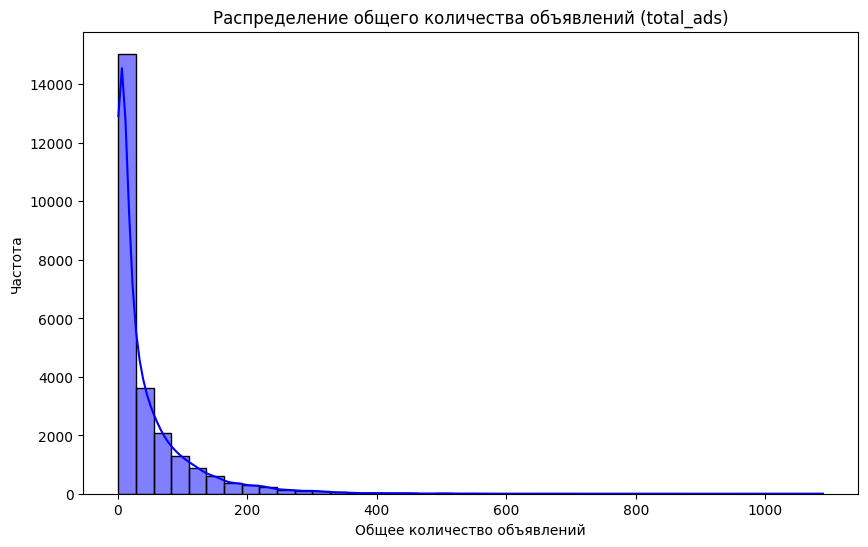

In [50]:
# Гистограмма для total_ads
plt.figure(figsize=(10, 6))
sns.histplot(user_agg['total_ads'], bins=40, kde=True, color='blue')
plt.title('Распределение общего количества объявлений (total_ads)')
plt.xlabel('Общее количество объявлений')
plt.ylabel('Частота')
plt.show()

- Большинство пользователей видели относительно небольшое количество объявлений (до 50).
- Распределение имеет длинный "хвост", что говорит о том, что у некоторых пользователей было значительно больше показов, но таких случаев мало.
- Наибольшее количество пользователей (более 14,000) видели менее 10 объявлений.
- Число пользователей, которые видели более 200 объявлений, резко уменьшается, а случаи с более чем 400 объявлениями крайне редки.

2. Распределение средней стоимости показов (avg_cpm)

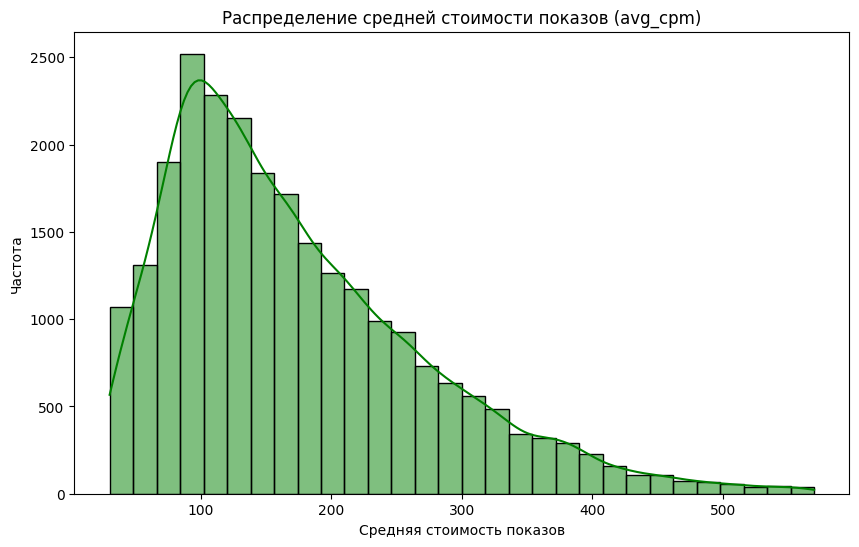

In [51]:
# Гистограмма для avg_cpm
plt.figure(figsize=(10, 6))
sns.histplot(user_agg['avg_cpm'], bins=30, kde=True, color='green')
plt.title('Распределение средней стоимости показов (avg_cpm)')
plt.xlabel('Средняя стоимость показов')
plt.ylabel('Частота')
plt.show()

- Распределение сильно скошено вправо, что говорит о наличии большого количества низких ставок и меньшего числа более дорогих показов.
- Большинство значений находится в диапазоне от 50 до 200, с плавным снижением частоты для более высоких ставок.

3. Зависимость между total_ads и avg_cpm

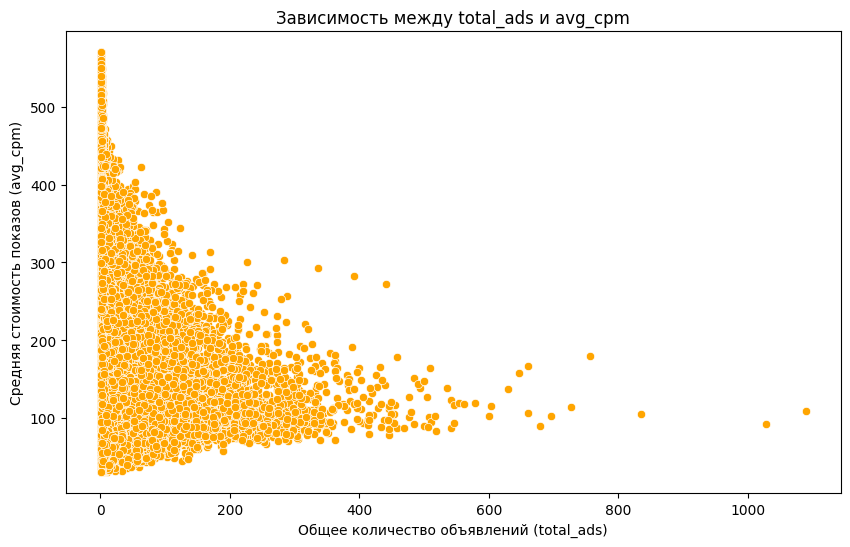

In [52]:
# График рассеяния
plt.figure(figsize=(10, 6))
sns.scatterplot(data=user_agg, x='total_ads', y='avg_cpm', color='orange')
plt.title('Зависимость между total_ads и avg_cpm')
plt.xlabel('Общее количество объявлений (total_ads)')
plt.ylabel('Средняя стоимость показов (avg_cpm)')
plt.show()

- Наблюдается обратная зависимость: чем больше объявлений показано пользователю, тем ниже средняя стоимость этих объявлений.
- Это может быть связано с тем, что более частые показы ассоциируются с менее дорогими рекламными кампаниями.

4. Распределение медианной стоимости показов (median_cpm)

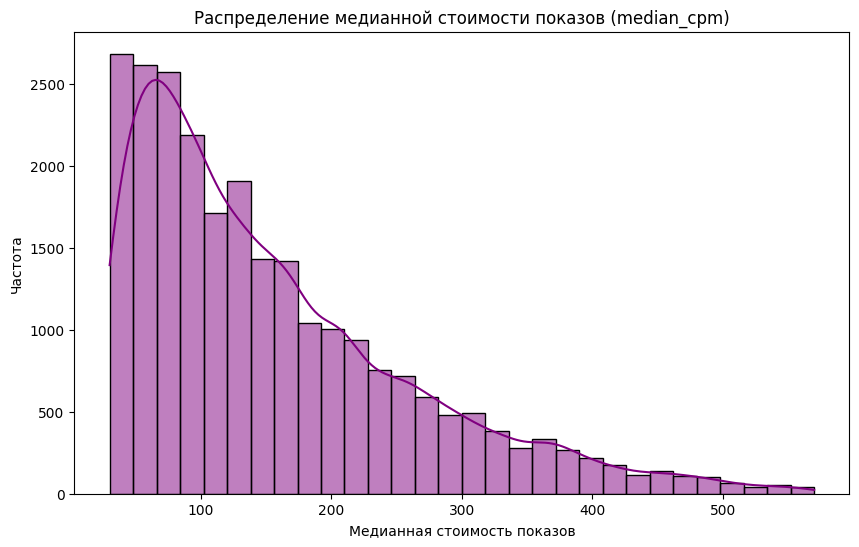

In [53]:
# Гистограмма для median_cpm
plt.figure(figsize=(10, 6))
sns.histplot(user_agg['median_cpm'], bins=30, kde=True, color='purple')
plt.title('Распределение медианной стоимости показов (median_cpm)')
plt.xlabel('Медианная стоимость показов')
plt.ylabel('Частота')
plt.show()

- Распределение аналогично avg_cpm, также сильно скошено вправо.
- Медианная стоимость для большинства пользователей ниже 200, что подтверждает схожесть тенденций со средней стоимостью.

5. Зависимость max_cpm от total_ads

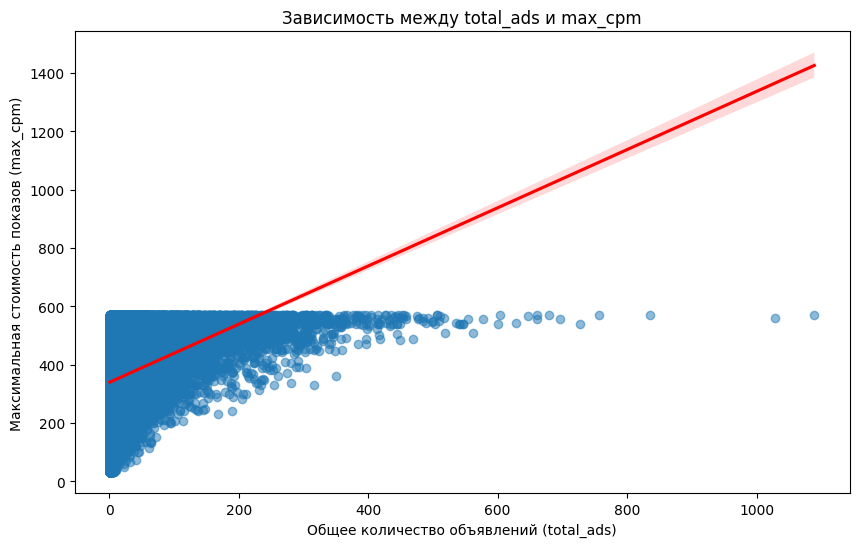

In [55]:
# График регрессии
plt.figure(figsize=(10, 6))
sns.regplot(data=user_agg, x='total_ads', y='max_cpm', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Зависимость между total_ads и max_cpm')
plt.xlabel('Общее количество объявлений (total_ads)')
plt.ylabel('Максимальная стоимость показов (max_cpm)')
plt.show()

- Наблюдается положительная линейная связь между общим количеством объявлений и максимальной стоимостью показов.
- Это может указывать на то, что пользователи с большим количеством показов имеют больше шансов увидеть объявления с высокой стоимостью.

Сделаем датасет с подсчетом рапределения просмотров рекламы на 24 часа для каждого пользователя

In [13]:
# Преобразуем нарастающие часы в часы суток
history['hour_of_day'] = history['hour'] % 24

# Проверим результат
history[['hour', 'hour_of_day']]

,hour,hour_of_day
0,10,10
1,8,8
2,7,7
3,18,18
4,8,8
...,...,...
1069926,382,22
1069927,360,0
1069928,381,21
1069929,383,23


In [14]:
# Расчет распределения часов просмотра рекламы
hour_distribution = history.groupby('user_id')['hour_of_day'].apply(
    lambda x: np.histogram(x, bins=24, range=(0, 23))[0]
).reset_index(name='hours_distribution')

# Преобразование гистограммы в отдельные колонки для часов
hour_columns = [f'hour_{i}' for i in range(24)]
hour_distribution_df = pd.DataFrame(hour_distribution['hours_distribution'].tolist(), columns=hour_columns)
hour_distribution = pd.concat([hour_distribution['user_id'], hour_distribution_df], axis=1)

# Рассмотрим полученный датасет
hour_distribution

,user_id,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,1,0,0,0,0,0,0,0,0,7,...,2,9,12,5,4,9,2,0,0,1
1,3,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,2,1,1
2,4,6,0,0,0,0,0,2,4,11,...,4,4,4,12,6,5,11,4,3,0
3,5,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,6,0,0,0,0,0,0,2,4,3,...,7,3,2,1,1,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24855,27764,2,0,0,0,0,0,1,2,1,...,0,0,1,0,0,2,2,6,7,15
24856,27765,0,1,1,6,4,11,6,4,1,...,5,0,0,2,6,3,3,0,0,1
24857,27766,4,0,0,0,1,0,3,2,4,...,0,2,2,5,10,3,2,2,3,1
24858,27767,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


1. Линейный график активности по часам суток

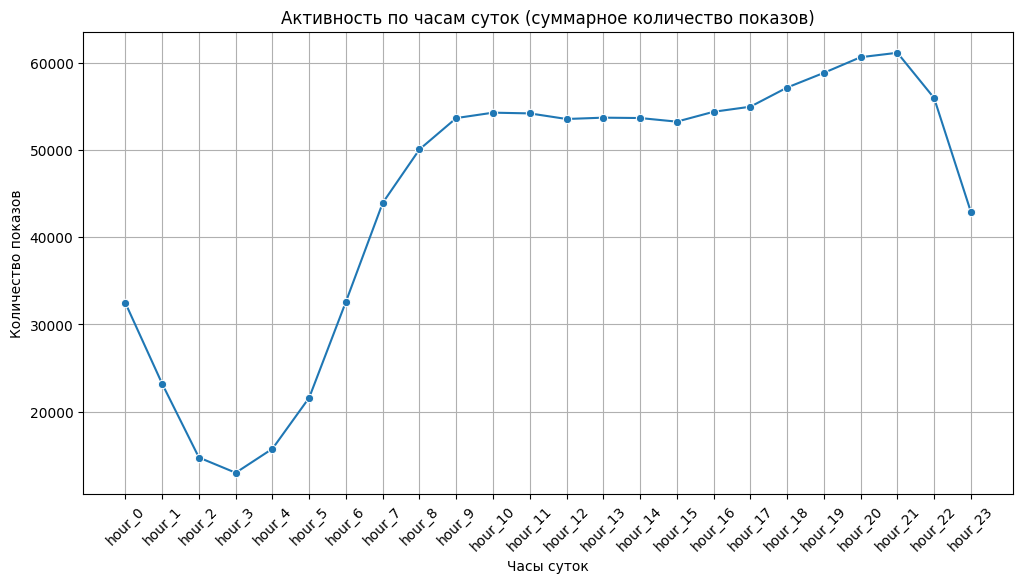

In [63]:
# Линейный график
plt.figure(figsize=(12, 6))
hourly_totals = hour_distribution[hour_columns].sum()
sns.lineplot(x=range(24), y=hourly_totals, marker='o')
plt.title('Активность по часам суток (суммарное количество показов)')
plt.xlabel('Часы суток')
plt.ylabel('Количество показов')
plt.xticks(ticks=range(24), labels=hour_columns, rotation=45)
plt.grid()
plt.show()

- Пики активности:
  - Наиболее высокая активность приходится на часы с 10:00 до 21:00, с пиком около 18:00–21:00.
  - Наименьшая активность наблюдается в ночные часы (1:00–6:00).
  
- Равномерность дневной активности:
  - Дневная активность пользователей относительно равномерна, с небольшой разницей между часами.

- Ночная активность минимальна:
  - В ночное время (с 2:00 до 6:00) количество показов заметно снижается, что можно связать с пониженной пользовательской активностью в этот период.

2. Распределение индивидуальной активности

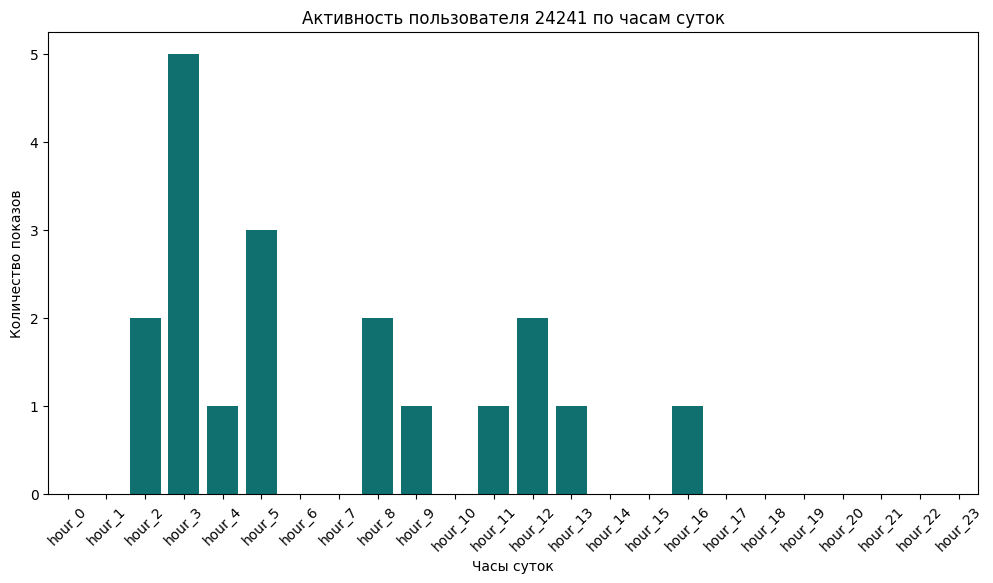

In [64]:
# Активность случайного пользователя
user_id = hour_distribution['user_id'].sample(1).iloc[0]  # Случайный user_id
user_hours = hour_distribution[hour_distribution['user_id'] == user_id][hour_columns].values.flatten()

plt.figure(figsize=(12, 6))
sns.barplot(x=range(24), y=user_hours, color='teal')
plt.title(f'Активность пользователя {user_id} по часам суток')
plt.xlabel('Часы суток')
plt.ylabel('Количество показов')
plt.xticks(ticks=range(24), labels=hour_columns, rotation=45)
plt.show()

- Индивидуальные пики:
  - Пользователь наиболее активен в начале дня (3:00–5:00) и около полудня (11:00–12:00).
  - Активность неравномерно распределена по часам, что может указывать на конкретные временные привычки пользователя.

- Перерывы в активности:
  - Есть периоды полного отсутствия активности (например, с 6:00 до 10:00 и с 18:00 до 22:00), что говорит о частичном использовании платформы.

Теперь объединим обе таблицы

In [15]:
# Объединение user_agg и hour_distribution
user_agg = user_agg.merge(hour_distribution, on='user_id', how='left')
user_agg

,user_id,total_ads,avg_cpm,median_cpm,max_cpm,hour_0,hour_1,hour_2,hour_3,hour_4,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,1,79,111.247848,90.000,361.52,0,0,0,0,0,...,2,9,12,5,4,9,2,0,0,1
1,3,7,321.588571,263.760,531.22,0,0,0,0,0,...,1,0,0,0,0,0,0,2,1,1
2,4,126,45.086429,30.245,255.36,6,0,0,0,0,...,4,4,4,12,6,5,11,4,3,0
3,5,9,91.055556,42.500,390.00,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,6,35,226.118857,234.000,496.95,0,0,0,0,0,...,7,3,2,1,1,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24855,27764,41,179.386098,170.000,400.92,2,0,0,0,0,...,0,0,1,0,0,2,2,6,7,15
24856,27765,75,130.001333,110.640,455.00,0,1,1,6,4,...,5,0,0,2,6,3,3,0,0,1
24857,27766,52,138.974231,120.000,342.00,4,0,0,0,1,...,0,2,2,5,10,3,2,2,3,1
24858,27767,1,143.880000,143.880,143.88,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## <a href="#22">Агрегация по площадкам (publisher)</a>

Теперь сделаем агрегацию по площадкам, где размещается объявление

In [16]:
# # Агрегация по площадкам
publisher_agg = history.groupby('publisher').agg(
    total_ads=('cpm', 'count'),
    avg_cpm=('cpm', 'mean'),
    median_cpm=('cpm', 'median'),
    max_cpm=('cpm', 'max')
).reset_index()

publisher_agg

,publisher,total_ads,avg_cpm,median_cpm,max_cpm
0,1,648727,139.258345,104.750,570.00
1,2,252678,154.469666,120.000,570.00
2,3,66699,136.993496,96.480,570.00
3,4,2272,89.444190,62.940,565.11
4,5,6762,144.780482,105.000,570.00
5,6,5762,82.412383,45.000,570.00
6,7,59246,157.320954,117.500,570.00
7,8,3599,111.002167,81.710,570.00
8,9,10092,94.828052,66.555,570.00
9,10,4105,94.286565,60.000,570.00


1. Горизонтальный бар-график общего количества объявлений на площадках

/var/folders/01/wgcp1v9n5zjdx14pvmwxt4mc0000gn/T/ipykernel_23089/2766973792.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


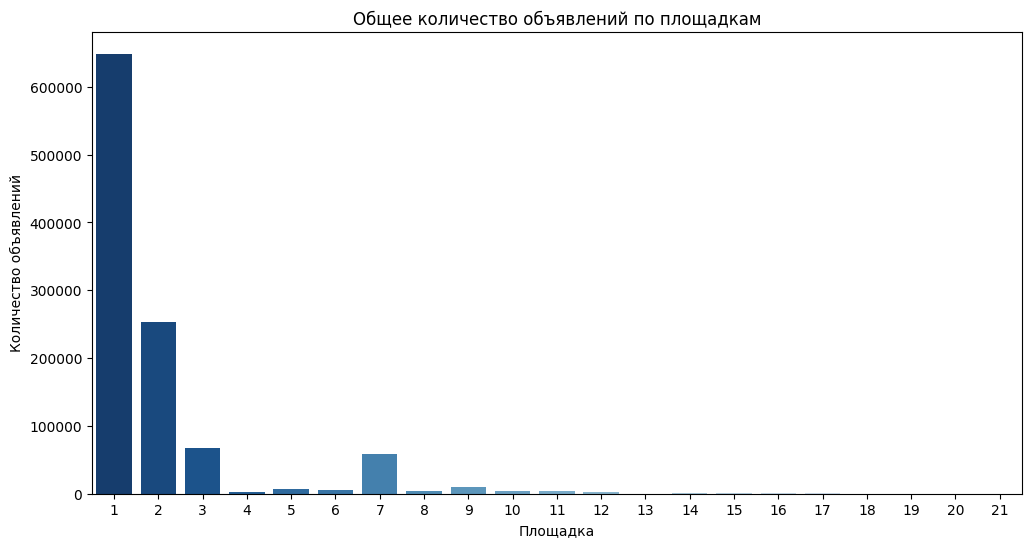

In [70]:
# Построим график
plt.figure(figsize=(12, 6))
sns.barplot(
    data=publisher_agg, 
    y='total_ads', 
    x='publisher', 
    palette='Blues_r'
)
plt.title('Общее количество объявлений по площадкам')
plt.xlabel('Площадка')
plt.ylabel('Количество объявлений')
plt.show()

- С большим отрывом от всех больше всего объявлений на площадке №1, далее идут площадки №2, №3, №7

2. Сравнительная диаграмма по всем метрикам (группированный бар-график)

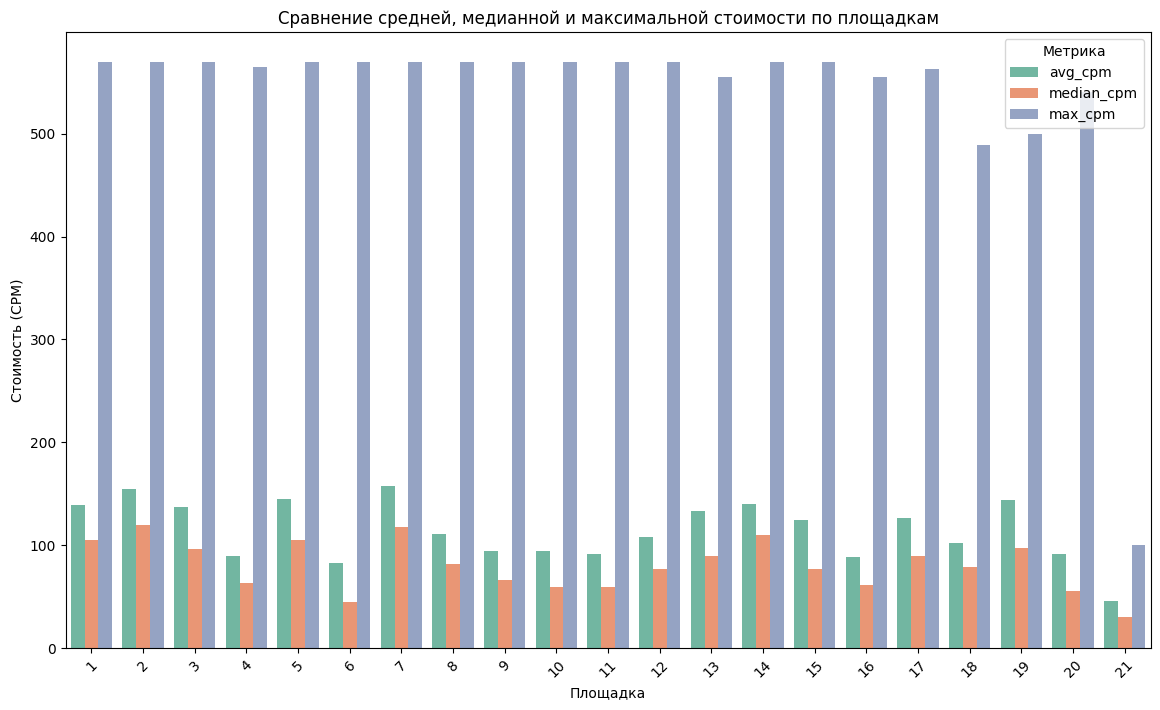

In [68]:
# Построим график
plt.figure(figsize=(14, 8))
metrics = publisher_agg.melt(id_vars='publisher', value_vars=['avg_cpm', 'median_cpm', 'max_cpm'], 
                             var_name='Metric', value_name='Value')

sns.barplot(
    data=metrics, 
    x='publisher', 
    y='Value', 
    hue='Metric', 
    palette='Set2'
)
plt.title('Сравнение средней, медианной и максимальной стоимости по площадкам')
plt.xlabel('Площадка')
plt.ylabel('Стоимость (CPM)')
plt.xticks(rotation=45)
plt.legend(title='Метрика')
plt.show()

- Средняя стоимость (avg_cpm) для большинства площадок лежит в диапазоне от 80 до 160 CPM.
- Медианная стоимость (median_cpm) практически одинаковая для всех площадок, с небольшими колебаниями от 60 до 120 CPM.
- Максимальная стоимость (max_cpm) сильно варьируется, с резкими пиками для некоторых площадок, что может указывать на большие аукционы или экстремальные ставки на данных площадках.

## <a href="#23">Сессии пользователей</a>

Выведем новый столбец в номером сессии `session_id`.

Из условия задачи:
- Система запоминает все объявления, который видел пользователь в течении сессии и не показывает их, даже если это самые дорогие объявления в аукционе.  Новая сессия начинается после отсутсвия показов рекламы пользователю в течении 6 часов.

In [17]:
# Сортировка данных для вычисления сессий
history = history.sort_values(by=['user_id', 'hour'])

# Вычисление сессий
history['time_diff'] = history.groupby('user_id')['hour'].diff().fillna(0)
history['new_session'] = (history['time_diff'] > 6).astype(int)
history['session_id'] = history.groupby('user_id')['new_session'].cumsum()
history

,hour,cpm,publisher,user_id,hour_of_day,time_diff,new_session,session_id
296,8,165.0,1,1,8,0.0,0,0
972,9,53.2,1,1,9,1.0,0,0
3297,9,36.0,1,1,9,0.0,0,0
6377,9,51.0,1,1,9,0.0,0,0
1049164,19,31.5,1,1,19,10.0,1,1
...,...,...,...,...,...,...,...,...
733215,1188,285.0,2,27768,12,46.0,1,13
740224,1188,205.0,12,27768,12,0.0,0,13
988910,1216,210.0,2,27768,16,28.0,1,14
875868,1410,179.8,2,27768,18,194.0,1,15


Далее рассмотрим сессии пользователей и тоже сделаем по ним агрециии !!!

In [18]:
# Агрегация сессий
session_stats = history.groupby(['user_id', 'session_id']).agg(
    session_ads=('cpm', 'count')
).reset_index()

# Агрегация сессий по пользователям
session_agg = session_stats.groupby('user_id').agg(
    avg_ads_per_session=('session_ads', 'mean'),
    max_ads_per_session=('session_ads', 'max')
).reset_index()

session_agg

,user_id,avg_ads_per_session,max_ads_per_session
0,1,2.135135,7
1,3,1.000000,1
2,4,2.000000,7
3,5,1.285714,2
4,6,1.521739,3
...,...,...,...
24855,27764,1.464286,3
24856,27765,1.785714,7
24857,27766,1.677419,6
24858,27767,1.000000,1


1. Распределение среднего количества объявлений на сессию 

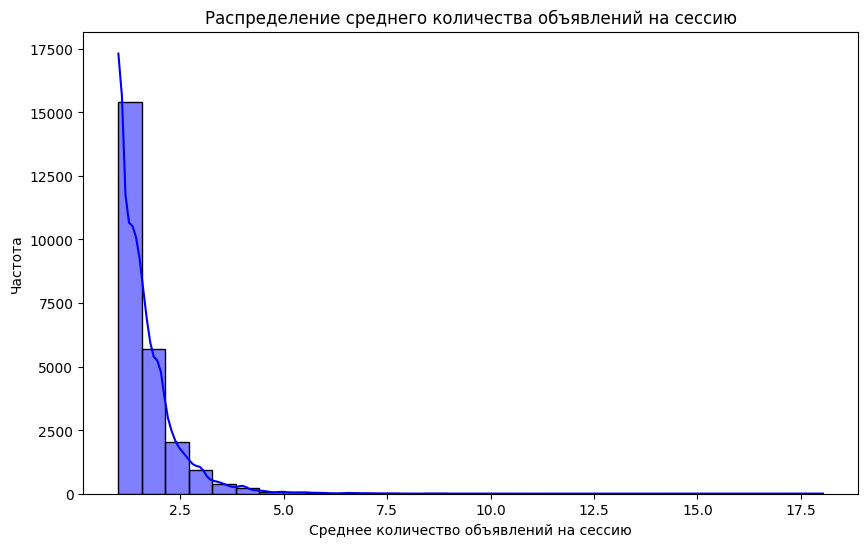

In [72]:
# Построим график
plt.figure(figsize=(10, 6))
sns.histplot(session_agg['avg_ads_per_session'], bins=30, kde=True, color='blue')
plt.title('Распределение среднего количества объявлений на сессию')
plt.xlabel('Среднее количество объявлений на сессию')
plt.ylabel('Частота')
plt.show()

- Распределение среднего количества объявлений на сессию:

    - Распределение имеет сильный правый перекос (длинный "хвост"), что характерно для данных с преобладанием небольших значений.
    - Большинство пользователей видят в среднем от 1 до 2 объявлений за одну сессию.
    - Очень небольшое число пользователей имеют среднее количество объявлений на сессию больше 5, что может быть вызвано редкими, но длинными сессиями.

- Особенности данных:

    - Данные показывают, что пользователи, как правило, не сильно перегружены количеством объявлений в одной сессии.
    - Аномальные значения в "хвосте" могут потребовать дополнительного анализа — они могут свидетельствовать о необычном - пользовательском поведении или технических особенностях подсчета.

2. Распределение максимального количества объявлений на сессию 

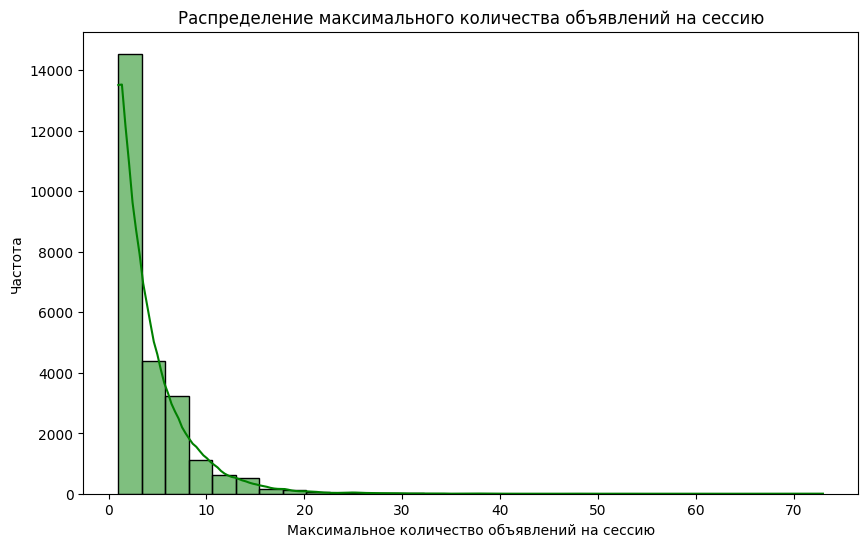

In [73]:
# Построим график
plt.figure(figsize=(10, 6))
sns.histplot(session_agg['max_ads_per_session'], bins=30, kde=True, color='green')
plt.title('Распределение максимального количества объявлений на сессию')
plt.xlabel('Максимальное количество объявлений на сессию')
plt.ylabel('Частота')
plt.show()

- Большинство пользователей видят максимум от 1 до 5 объявлений за одну сессию.
- Распределение имеет длинный хвост, что свидетельствует о наличии пользователей с большим количеством объявлений в отдельных сессиях (до 70).
- Это может указывать на активность определенных групп пользователей или особенности площадок.

3. Выделение пользователей с экстремальными значениями

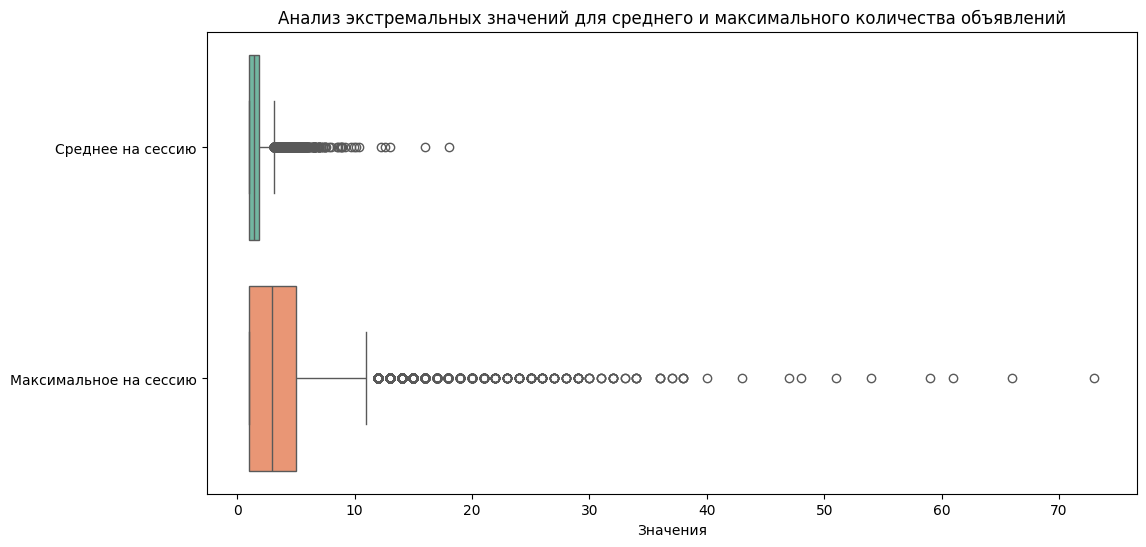

In [75]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=session_agg[['avg_ads_per_session', 'max_ads_per_session']], orient='h', palette='Set2')
plt.title('Анализ экстремальных значений для среднего и максимального количества объявлений')
plt.xlabel('Значения')
plt.yticks([0, 1], ['Среднее на сессию', 'Максимальное на сессию'])
plt.show()


- Среднее количество объявлений на сессию в большинстве случаев находится в диапазоне от 1 до 2, но присутствует много выбросов, что указывает на пользователей с аномально высоким средним значением.
- Максимальное количество объявлений на сессию показывает схожую тенденцию, но выбросы более выражены и доходят до 50+ объявлений.
- Это различие между средними и максимальными значениями на сессию подчеркивает важность сегментации пользователей и площадок, чтобы учитывать различия в активности.

## <a href="#24">Добавление данных пользователей</a> 

In [77]:
# Посмотрим количество пользователей по полу
users['sex'].value_counts()

sex
1    14249
2    12860
0       28
Name: count, dtype: int64

Преобразуем в бинарные данные столбец по полу, так как всего 30 пользователей не указали пол. Также разделим пользователей по группам возрастов

In [78]:
# Добавление данных пользователей
users['sex_binary'] = (users['sex'] == 1).astype(int)
users['age_group'] = pd.cut(users['age'], bins=[0, 18, 35, 50, np.inf], labels=['0-18', '19-35', '36-50', '51+'], right=False)
users

,user_id,sex,age,city_id,sex_binary,age_group
0,0,2,19,0,0,19-35
1,1,1,0,1,1,0-18
2,2,2,24,2,0,19-35
3,3,1,20,3,1,19-35
4,4,2,29,4,0,19-35
...,...,...,...,...,...,...
27132,27764,1,38,295,1,36-50
27133,27765,2,30,79,0,19-35
27134,27766,2,21,1953,0,19-35
27135,27767,2,17,0,0,0-18


Также определим топ-10 городов по количеству пользователей, а остальные определим как `other`

In [79]:
# Группировка городов по частоте
city_counts = users['city_id'].value_counts()
top_cities = city_counts.nlargest(10).index
users['city_group'] = users['city_id'].apply(lambda x: x if x in top_cities else 'other')
users

,user_id,sex,age,city_id,sex_binary,age_group,city_group
0,0,2,19,0,0,19-35,0
1,1,1,0,1,1,0-18,other
2,2,2,24,2,0,19-35,other
3,3,1,20,3,1,19-35,3
4,4,2,29,4,0,19-35,other
...,...,...,...,...,...,...,...
27132,27764,1,38,295,1,36-50,other
27133,27765,2,30,79,0,19-35,other
27134,27766,2,21,1953,0,19-35,other
27135,27767,2,17,0,0,0-18,0


1. Распределение пользователей по полу

/var/folders/01/wgcp1v9n5zjdx14pvmwxt4mc0000gn/T/ipykernel_23089/4277134962.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=users, x='sex_binary', palette='Set2')


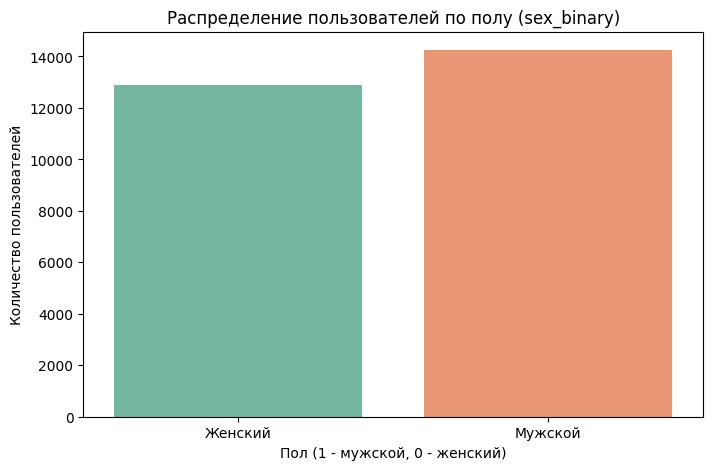

In [80]:
# Гистограмма для sex_binary
plt.figure(figsize=(8, 5))
sns.countplot(data=users, x='sex_binary', palette='Set2')
plt.title('Распределение пользователей по полу (sex_binary)')
plt.xlabel('Пол (1 - мужской, 0 - женский)')
plt.ylabel('Количество пользователей')
plt.xticks([0, 1], ['Женский', 'Мужской'])
plt.show()

- Пропорции между мужскими (1) и женскими (0) пользователями почти равны, с небольшим перевесом в сторону мужчин.
- Это указывает на равномерное распределение пользователей по полу.

2. Распределение пользователей по возрасту и возрастный группам

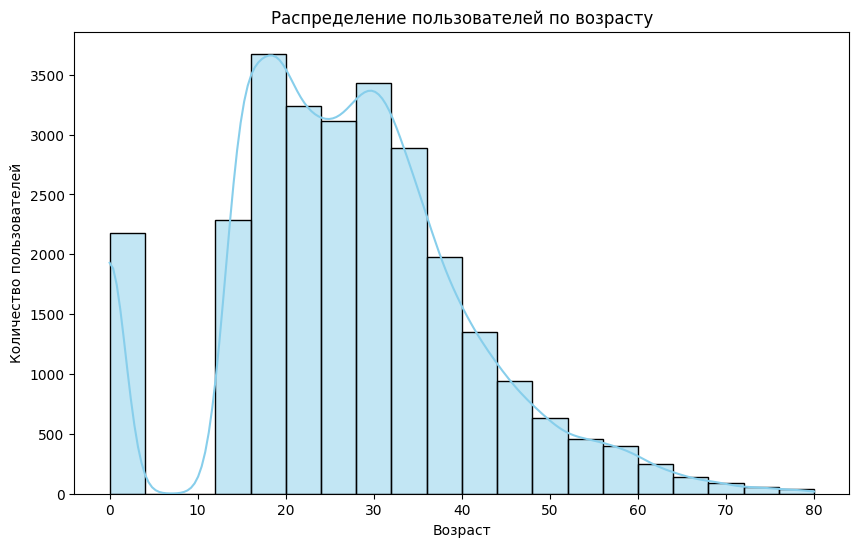

In [81]:
# Гистограмма для возраста (age)
plt.figure(figsize=(10, 6))
sns.histplot(users['age'], bins=20, kde=True, color='skyblue')
plt.title('Распределение пользователей по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

- Большая часть пользователей находится в возрасте от 18 до 35 лет, что совпадает с активной возрастной группой в цифровой среде.
- Наблюдается заметный спад числа пользователей после 50 лет.

/var/folders/01/wgcp1v9n5zjdx14pvmwxt4mc0000gn/T/ipykernel_23089/2316484977.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=users, x='age_group', palette='Pastel1')


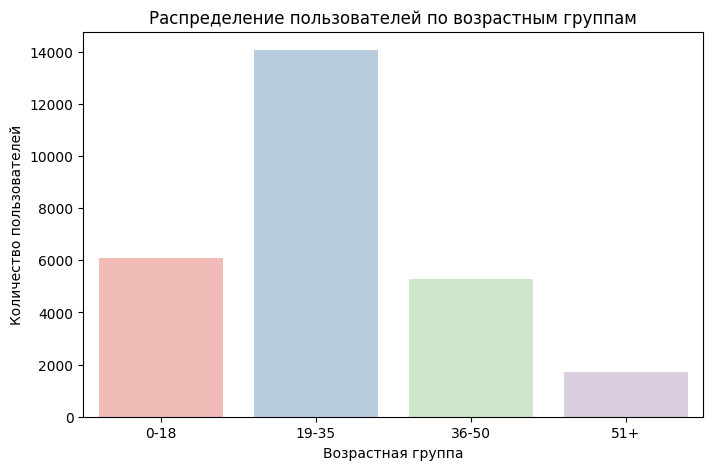

In [82]:
# Гистограмма для возрастных групп (age_group)
plt.figure(figsize=(8, 5))
sns.countplot(data=users, x='age_group', palette='Pastel1')
plt.title('Распределение пользователей по возрастным группам')
plt.xlabel('Возрастная группа')
plt.ylabel('Количество пользователей')
plt.show()

- Наиболее многочисленная группа — 19-35 лет.
- Группы 0-18 и 36-50 имеют примерно одинаковое количество пользователей, тогда как группа 51+ является самой малочисленной.

3. Распределение пользвателей по городам

/var/folders/01/wgcp1v9n5zjdx14pvmwxt4mc0000gn/T/ipykernel_23089/125014831.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=users, x='city_group', order=users['city_group'].value_counts().index, palette='coolwarm')


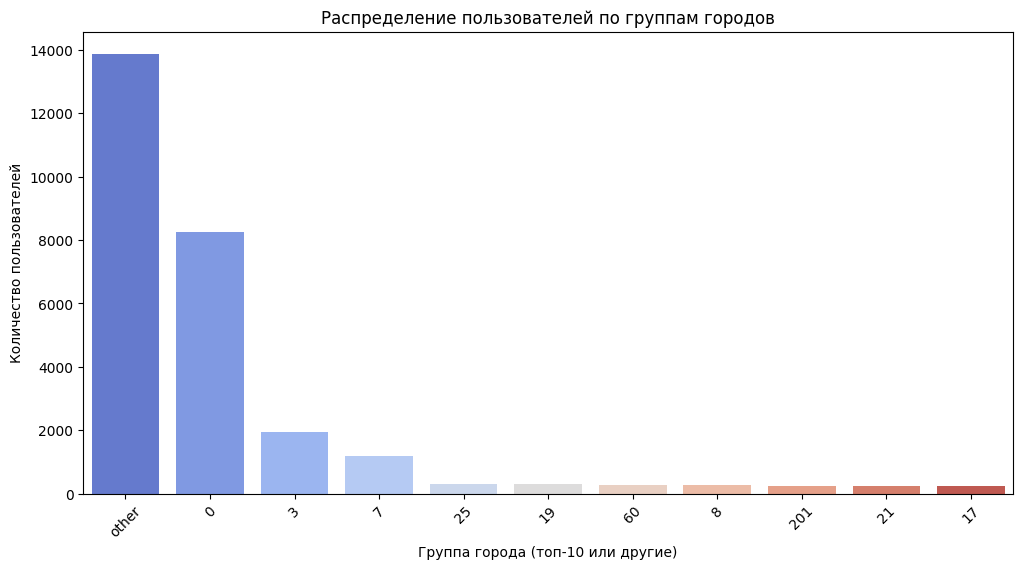

In [83]:
# Гистограмма для групп городов (city_group)
plt.figure(figsize=(12, 6))
sns.countplot(data=users, x='city_group', order=users['city_group'].value_counts().index, palette='coolwarm')
plt.title('Распределение пользователей по группам городов')
plt.xlabel('Группа города (топ-10 или другие)')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45)
plt.show()

- Большинство пользователей находятся в категориях "other", далее значитеьная часть пользователей не указали город, а самым топовым по количеству пользователей - город 3.

 ## <a href="#25">Объединение фичей</a> 

Объединим фичи с пользователями и с сессиями и сохраним. Отдельно сохраним датасет с площадками

In [22]:
# Объединение всех фичей
user_features = user_agg.merge(session_agg, on='user_id', how='left')
user_features = user_features.merge(users, on='user_id', how='left')

In [23]:
# Посмотрим полученный датасет
user_features

,user_id,total_ads,avg_cpm,median_cpm,max_cpm,hour_0,hour_1,hour_2,hour_3,hour_4,...,hour_22,hour_23,avg_ads_per_session,max_ads_per_session,sex,age,city_id,sex_binary,age_group,city_group
0,1,79,111.247848,90.000,361.52,0,0,0,0,0,...,0,1,2.135135,7,1.0,0.0,1.0,1.0,0-18,other
1,3,7,321.588571,263.760,531.22,0,0,0,0,0,...,1,1,1.000000,1,1.0,20.0,3.0,1.0,19-35,3
2,4,126,45.086429,30.245,255.36,6,0,0,0,0,...,3,0,2.000000,7,2.0,29.0,4.0,0.0,19-35,other
3,5,9,91.055556,42.500,390.00,0,0,0,0,0,...,0,0,1.285714,2,2.0,22.0,5.0,0.0,19-35,other
4,6,35,226.118857,234.000,496.95,0,0,0,0,0,...,0,0,1.521739,3,1.0,21.0,6.0,1.0,19-35,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24855,27764,41,179.386098,170.000,400.92,2,0,0,0,0,...,7,15,1.464286,3,1.0,38.0,295.0,1.0,36-50,other
24856,27765,75,130.001333,110.640,455.00,0,1,1,6,4,...,0,1,1.785714,7,2.0,30.0,79.0,0.0,19-35,other
24857,27766,52,138.974231,120.000,342.00,4,0,0,0,1,...,3,1,1.677419,6,2.0,21.0,1953.0,0.0,19-35,other
24858,27767,1,143.880000,143.880,143.88,0,0,0,0,0,...,0,0,1.000000,1,2.0,17.0,0.0,0.0,0-18,0


In [24]:
# Посмотрим информацию по датасету
user_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24860 entries, 0 to 24859
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   user_id              24860 non-null  int64   
 1   total_ads            24860 non-null  int64   
 2   avg_cpm              24860 non-null  float64 
 3   median_cpm           24860 non-null  float64 
 4   max_cpm              24860 non-null  float64 
 5   hour_0               24860 non-null  int64   
 6   hour_1               24860 non-null  int64   
 7   hour_2               24860 non-null  int64   
 8   hour_3               24860 non-null  int64   
 9   hour_4               24860 non-null  int64   
 10  hour_5               24860 non-null  int64   
 11  hour_6               24860 non-null  int64   
 12  hour_7               24860 non-null  int64   
 13  hour_8               24860 non-null  int64   
 14  hour_9               24860 non-null  int64   
 15  hour_10            

## <a href="#26">Создание целевых переменных</a> 

Вот несколько условий по задаче:
- Если ставка объявления `cpm` больше всех ставок всех остальных участников: со 100% вероятность выигрывает объявление со ставкой `cpm`
- Если ставка объявления `cpm` равна максимальной ставке среди всех остальных участников: объявление со ставкой `cpm` выигрывает с вероятностью в 50%. В реальном аукционе объявление может выигрывать по совершенно другим правилам и вероятностям, это упрощение для моделирования конкретно в данном датасете. 

Нам необходимо выявить веротяность выигрыша для каждой ставки

In [25]:
# Сортируем данные для упрощения обработки сессий и вычислений
history = history.sort_values(by=['user_id', 'hour'])

# Определяем max_cpm среди других участников на той же площадке и в тот же час
history['max_cpm_other'] = history.groupby(['hour', 'publisher'])['cpm'].transform(
    lambda x: x.nlargest(2).iloc[-1] if len(x) > 1 else x.iloc[0]
)

In [26]:
history

,hour,cpm,publisher,user_id,hour_of_day,time_diff,new_session,session_id,max_cpm_other
296,8,165.0,1,1,8,0.0,0,0,525.00
972,9,53.2,1,1,9,1.0,0,0,534.36
3297,9,36.0,1,1,9,0.0,0,0,534.36
6377,9,51.0,1,1,9,0.0,0,0,534.36
1049164,19,31.5,1,1,19,10.0,1,1,538.15
...,...,...,...,...,...,...,...,...,...
733215,1188,285.0,2,27768,12,46.0,1,13,531.76
740224,1188,205.0,12,27768,12,0.0,0,13,51.60
988910,1216,210.0,2,27768,16,28.0,1,14,552.35
875868,1410,179.8,2,27768,18,194.0,1,15,517.50


In [27]:
# Вычисляем вероятность выигрыша в аукционе
history['win_probability'] = np.where(
    history['cpm'] > history['max_cpm_other'], 1,  # Победа с вероятностью 1, если ставка больше всех остальных
    np.where(history['cpm'] == history['max_cpm_other'], 0.5, 0)  # Ничья — вероятность 0.5, иначе 0
)

In [28]:
# Формируем уникальные просмотры с учетом правила "не показывать повторно" и сессий (разрыв > 6 часов)
def calculate_unique_views_with_probability(group):
    seen_ads = set()
    unique_views = []
    last_seen_time = {}
    for _, row in group.iterrows():
        user_id = row['user_id']
        if user_id in seen_ads:
            # Учет новой сессии
            if row['hour'] - last_seen_time[user_id] > 6:
                seen_ads.remove(user_id)
            else:
                unique_views.append(0)
                continue
        # Вероятностный учет просмотра
        unique_views.append(row['win_probability'])
        if row['win_probability'] > 0:
            seen_ads.add(user_id)
            last_seen_time[user_id] = row['hour']
    return unique_views

In [29]:
# Применяем к каждому пользователю
history['unique_view'] = (
    history.groupby('user_id', group_keys=False).apply(
        lambda group: pd.Series(calculate_unique_views_with_probability(group))
    ).values  # Конвертируем результат в массив для корректного присоединения
)

/var/folders/01/wgcp1v9n5zjdx14pvmwxt4mc0000gn/T/ipykernel_23089/4162637202.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  history.groupby('user_id', group_keys=False).apply(


In [30]:
history['unique_view'] = history['unique_view'].astype(float)  # Приводим уникальные просмотры к float

In [31]:
history

,hour,cpm,publisher,user_id,hour_of_day,time_diff,new_session,session_id,max_cpm_other,win_probability,unique_view
296,8,165.0,1,1,8,0.0,0,0,525.00,0.0,0.0
972,9,53.2,1,1,9,1.0,0,0,534.36,0.0,0.0
3297,9,36.0,1,1,9,0.0,0,0,534.36,0.0,0.0
6377,9,51.0,1,1,9,0.0,0,0,534.36,0.0,0.0
1049164,19,31.5,1,1,19,10.0,1,1,538.15,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
733215,1188,285.0,2,27768,12,46.0,1,13,531.76,0.0,0.0
740224,1188,205.0,12,27768,12,0.0,0,13,51.60,1.0,1.0
988910,1216,210.0,2,27768,16,28.0,1,14,552.35,0.0,0.0
875868,1410,179.8,2,27768,18,194.0,1,15,517.50,0.0,0.0


In [32]:
# Вычисляем целевые переменные
def calculate_view_targets(group):
    cumsum = group['unique_view'].cumsum()
    return {
        'at_least_one': (cumsum >= 1).mean(),
        'at_least_two': (cumsum >= 2).mean(),
        'at_least_three': (cumsum >= 3).mean()
    }

# Группируем данные по пользователю и применяем подсчет целевых переменных
view_targets = (
    history.groupby('user_id').apply(calculate_view_targets).apply(pd.Series).reset_index()
)

# Переименовываем столбцы для удобства
view_targets.columns = ['user_id', 'at_least_one', 'at_least_two', 'at_least_three']

view_targets

/var/folders/01/wgcp1v9n5zjdx14pvmwxt4mc0000gn/T/ipykernel_23089/3308735392.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  history.groupby('user_id').apply(calculate_view_targets).apply(pd.Series).reset_index()


,user_id,at_least_one,at_least_two,at_least_three
0,1,0.000000,0.000000,0.0
1,3,1.000000,0.000000,0.0
2,4,0.000000,0.000000,0.0
3,5,0.000000,0.000000,0.0
4,6,0.428571,0.171429,0.0
...,...,...,...,...
24855,27764,0.000000,0.000000,0.0
24856,27765,0.000000,0.000000,0.0
24857,27766,0.000000,0.000000,0.0
24858,27767,0.000000,0.000000,0.0


In [33]:
# Посмотрим характеристики
view_targets.describe()

,user_id,at_least_one,at_least_two,at_least_three
count,24860.000000,24860.000000,24860.000000,24860.000000
mean,13904.366734,0.196475,0.070966,0.037512
std,8020.375554,0.340897,0.203516,0.146608
min,1.000000,0.000000,0.000000,0.000000
25%,6952.750000,0.000000,0.000000,0.000000
50%,13936.500000,0.000000,0.000000,0.000000
75%,20852.250000,0.310181,0.000000,0.000000
max,27768.000000,1.000000,0.995327,0.981443


In [34]:
# Посмотрим характеристики
validate_answers.describe()

,at_least_one,at_least_two,at_least_three
count,1008.000000,1008.000000,1008.000000
mean,0.115441,0.065805,0.047170
std,0.146146,0.117812,0.099029
min,0.000000,0.000000,0.000000
25%,0.016650,0.000000,0.000000
50%,0.055250,0.009800,0.001400
75%,0.158700,0.078125,0.048950
max,0.930700,0.909700,0.883400


Не знаю насколько правильно соотносить полученные характеристики, но в принципе мы получили подобные статистики с истинными ответами

In [35]:
# Объединение целевых признаков с user_features
user_features = user_features.merge(view_targets, on='user_id', how='left')

In [36]:
pd.set_option('display.max_columns', None)

Посмотрим итоговый датасет, на котором будем учить данные

In [37]:
user_features

,user_id,total_ads,avg_cpm,median_cpm,max_cpm,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,avg_ads_per_session,max_ads_per_session,sex,age,city_id,sex_binary,age_group,city_group,at_least_one,at_least_two,at_least_three
0,1,79,111.247848,90.000,361.52,0,0,0,0,0,0,0,0,7,15,4,6,3,0,2,9,12,5,4,9,2,0,0,1,2.135135,7,1.0,0.0,1.0,1.0,0-18,other,0.000000,0.000000,0.0
1,3,7,321.588571,263.760,531.22,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,2,1,1,1.000000,1,1.0,20.0,3.0,1.0,19-35,3,1.000000,0.000000,0.0
2,4,126,45.086429,30.245,255.36,6,0,0,0,0,0,2,4,11,19,10,8,6,7,4,4,4,12,6,5,11,4,3,0,2.000000,7,2.0,29.0,4.0,0.0,19-35,other,0.000000,0.000000,0.0
3,5,9,91.055556,42.500,390.00,0,0,0,0,0,0,0,0,0,0,0,1,3,3,1,0,0,0,1,0,0,0,0,0,1.285714,2,2.0,22.0,5.0,0.0,19-35,other,0.000000,0.000000,0.0
4,6,35,226.118857,234.000,496.95,0,0,0,0,0,0,2,4,3,2,4,2,1,1,7,3,2,1,1,0,2,0,0,0,1.521739,3,1.0,21.0,6.0,1.0,19-35,other,0.428571,0.171429,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24855,27764,41,179.386098,170.000,400.92,2,0,0,0,0,0,1,2,1,1,1,0,0,0,0,0,1,0,0,2,2,6,7,15,1.464286,3,1.0,38.0,295.0,1.0,36-50,other,0.000000,0.000000,0.0
24856,27765,75,130.001333,110.640,455.00,0,1,1,6,4,11,6,4,1,6,6,0,3,6,5,0,0,2,6,3,3,0,0,1,1.785714,7,2.0,30.0,79.0,0.0,19-35,other,0.000000,0.000000,0.0
24857,27766,52,138.974231,120.000,342.00,4,0,0,0,1,0,3,2,4,2,2,2,0,2,0,2,2,5,10,3,2,2,3,1,1.677419,6,2.0,21.0,1953.0,0.0,19-35,other,0.000000,0.000000,0.0
24858,27767,1,143.880000,143.880,143.88,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1.000000,1,2.0,17.0,0.0,0.0,0-18,0,0.000000,0.000000,0.0


### Описание столбцов

| **Название столбца**     | **Описание**                                                                 |
|---------------------------|-----------------------------------------------------------------------------|
| `user_id`                | Уникальный идентификатор пользователя.                                      |
| `total_ads`              | Общее количество объявлений, просмотренных пользователем.                  |
| `avg_cpm`                | Средняя стоимость показов рекламы (`cpm`) для пользователя.                |
| `median_cpm`             | Медианная стоимость показов рекламы (`cpm`) для пользователя.              |
| `max_cpm`                | Максимальная стоимость показов рекламы (`cpm`) для пользователя.           |
| `hour_0`, ..., `hour_23` | Количество объявлений, просмотренных пользователем в каждый час суток.      |
| `avg_ads_per_session`    | Среднее количество объявлений, просмотренных в одной сессии.               |
| `max_ads_per_session`    | Максимальное количество объявлений, просмотренных в одной сессии.          |
| `sex`                    | Пол пользователя (1 — мужской, 2 — женский).                               |
| `age`                    | Возраст пользователя.                                                      |
| `city_id`                | Уникальный идентификатор города проживания пользователя.                   |
| `sex_binary`             | Бинарное представление пола (1 — мужской, 0 — женский).                    |
| `age_group`              | Группа возраста пользователя (`0-18`, `19-35`, `36-50`, `51+`).            |
| `city_group`             | Группа города (топ-10 или `other`).                                        |
| `at_least_one`           | Доля показов, где пользователь видел объявление хотя бы один раз.          |
| `at_least_two`           | Доля показов, где пользователь видел объявление хотя бы два раза.          |
| `at_least_three`         | Доля показов, где пользователь видел объявление хотя бы три раза.          |

---

### Дополнительно:
- Столбцы `hour_0`, ..., `hour_23` показывают **количество показов** рекламы в каждом часу для каждого пользователя, а не бинарные значения.
- Целевые переменные `at_least_one`, `at_least_two`, `at_least_three` отражают вероятности, рассчитанные по уникальным просмотрам.

In [38]:
user_features.to_csv('./user_features.csv')